In [68]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import datetime as dt
import time

In [69]:
# portfolio of crypto
crypto = ['BTC-USD', 'ETH-USD', 'BNB-USD']

In [70]:
# import yfinance as yf

# # Download historical data from yf API
# data = yf.download(crypto, group_by='ticker', period="max")

# # download data to csv
# data.to_csv("crypto.csv")

In [71]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv("crypto.csv", header=[0,1], index_col=0)

# df.head()

In [72]:
# # Drop any rows that are completely NaN (e.g. 'Date' row)
# df = df.dropna(how='all')

# Forward fill missing values for each column
df = df.fillna(method='ffill')

# Backfill any remaining NaN values with 0
df = df.fillna(0)

# Convert all values to float
df = df.astype(float)

# Set the index to datetime
df.index = pd.to_datetime(df.index)

# From level 0 columns, replace '-USD' with empty string to keep only ticker symbols
df.columns = df.columns.set_levels(df.columns.levels[0].str.replace('-USD', ''), level=0)

# Show the result
df.head()

Ticker      ETH                                BTC                          \
Price      Open High  Low Close Volume        Open        High         Low   
Date                                                                         
2014-09-17  0.0  0.0  0.0   0.0    0.0  465.864014  468.174011  452.421997   
2014-09-18  0.0  0.0  0.0   0.0    0.0  456.859985  456.859985  413.104004   
2014-09-19  0.0  0.0  0.0   0.0    0.0  424.102997  427.834991  384.532013   
2014-09-20  0.0  0.0  0.0   0.0    0.0  394.673004  423.295990  389.882996   
2014-09-21  0.0  0.0  0.0   0.0    0.0  408.084991  412.425995  393.181000   

Ticker                              BNB                         
Price            Close      Volume Open High  Low Close Volume  
Date                                                            
2014-09-17  457.334015  21056800.0  0.0  0.0  0.0   0.0    0.0  
2014-09-18  424.440002  34483200.0  0.0  0.0  0.0   0.0    0.0  
2014-09-19  394.795990  37919700.0  0.0  0.0  0.0   0.0    0.0  
2014-09-20  408.903992  36863600.0  0.0  0.0  0.0   0.0    0.0  
2014-09-21  398.821014  26580100.0  0.0  0.0  0.0   0.0    0.0

In [73]:
btc = df['BTC']
eth = df['ETH'] 
bnb = df['BNB']

In [74]:
# create a list with the dataframes
crypto_dfs = [btc, eth, bnb]

In [75]:
# iterate over the list and calculate returns and drawdowns for each dataframe
crypto_names = ['BTC', 'ETH', 'BNB']
crypto_dfs = [btc, eth, bnb]

for name, crypto_df in zip(crypto_names, crypto_dfs):
    # Filter out rows where Close is 0 (before the asset existed)
    valid_data = crypto_df[crypto_df['Close'] > 0].copy()
    
    # Calculate simple returns with pct_change()
    valid_data['simple_returns'] = valid_data['Close'].pct_change().fillna(0)

    # Cumulative product of simple returns (correct for compounding)
    valid_data['cumprod_simple'] = (1 + valid_data['simple_returns']).cumprod() - 1

    valid_data['cumumax'] = valid_data['cumprod_simple'].cummax()

    valid_data['drawdown'] = (valid_data['cumprod_simple'] - valid_data['cumumax']) / (valid_data['cumumax'] + 1)
    
    # Update the original dataframe
    crypto_df.loc[valid_data.index, ['simple_returns', 'cumprod_simple', 'cumumax', 'drawdown']] = valid_data[['simple_returns', 'cumprod_simple', 'cumumax', 'drawdown']]
    
    max_drawdown = valid_data['drawdown'].min()
    print(f"Max Drawdown for {name}: {max_drawdown:.2%}")
    print(f"  Data range: {valid_data.index.min()} to {valid_data.index.max()}")

Max Drawdown for BTC: -83.40%
  Data range: 2014-09-17 00:00:00 to 2025-12-03 00:00:00
Max Drawdown for ETH: -93.96%
  Data range: 2017-11-09 00:00:00 to 2025-12-03 00:00:00
Max Drawdown for BNB: -80.10%
  Data range: 2017-11-09 00:00:00 to 2025-12-03 00:00:00


In [76]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4096 entries, 2014-09-17 to 2025-12-03
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            4096 non-null   float64
 1   High            4096 non-null   float64
 2   Low             4096 non-null   float64
 3   Close           4096 non-null   float64
 4   Volume          4096 non-null   float64
 5   simple_returns  4096 non-null   float64
 6   cumprod_simple  4096 non-null   float64
 7   cumumax         4096 non-null   float64
 8   drawdown        4096 non-null   float64
dtypes: float64(9)
memory usage: 449.0 KB


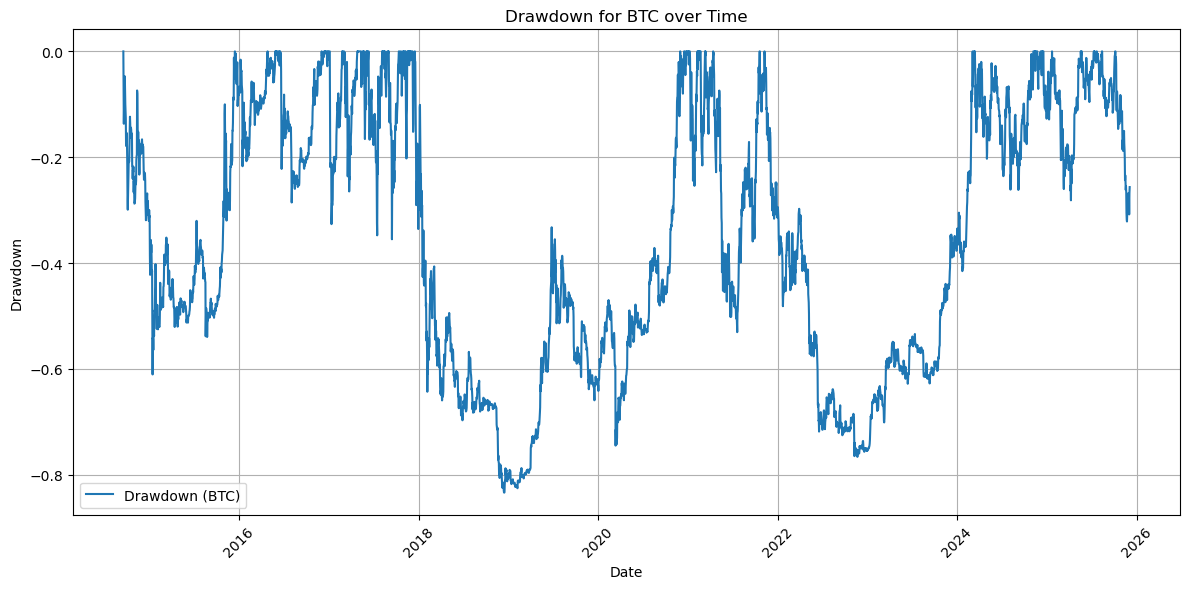

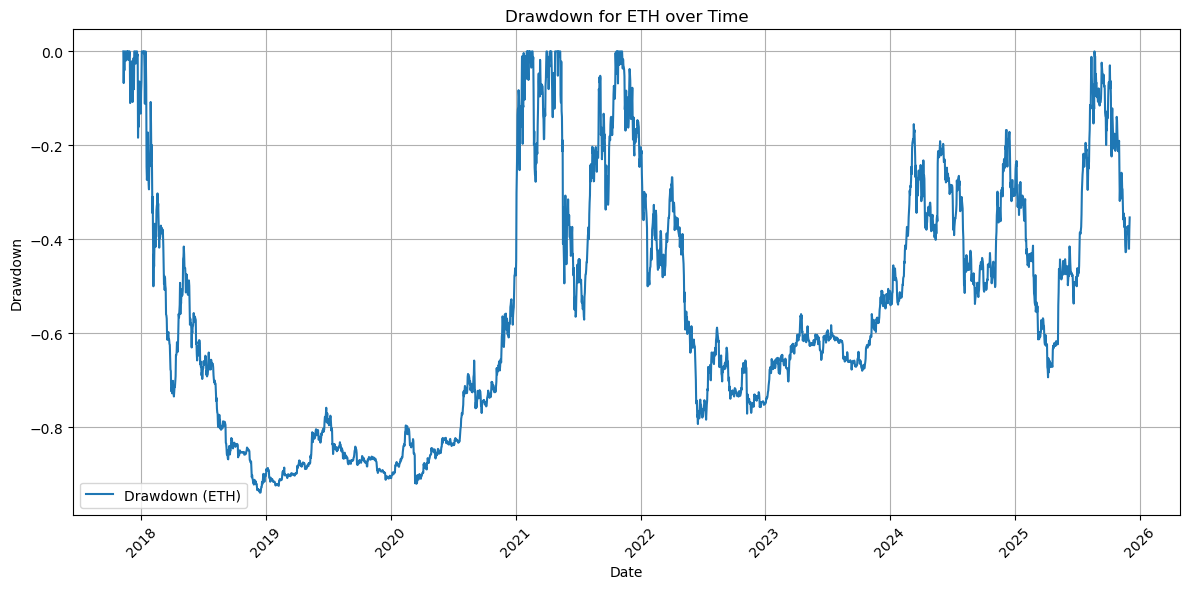

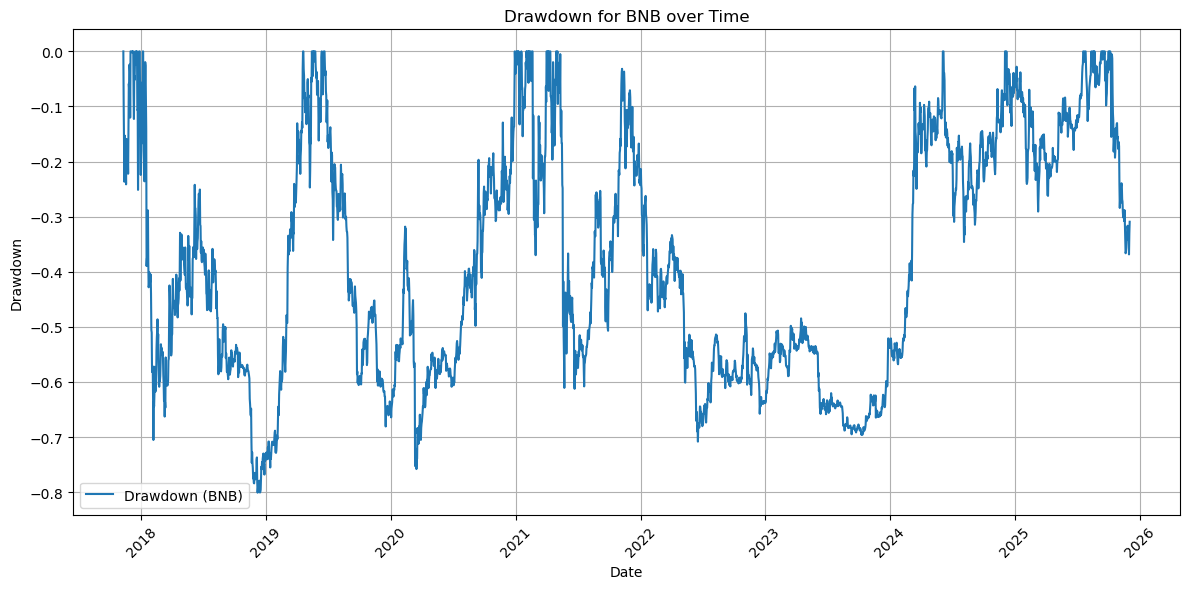

In [77]:
for name, crypto_df in zip(crypto_names, crypto_dfs):
    # plot drawdown
    plt.figure(figsize=(12, 6))
    plt.plot(crypto_df.index, crypto_df['drawdown'], label=f'Drawdown ({name})')
    plt.title(f'Drawdown for {name} over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.show()